In [1]:
import numpy as np
import bayes3d as b
from tqdm import tqdm
import jax
import jax.numpy as jnp
from bayes3d.rendering.nvdiffrast_jax.jax_renderer import Renderer as JaxRenderer
import matplotlib.pyplot as plt

GenJAX not installed. Importing bayes3d without genjax dependencies.


In [2]:
def projection(x=0.1, n=1.0, f=50.0):
    return jnp.array([[n/x,    0,            0,              0],
                      [  0,  n/x,            0,              0],
                      [  0,    0, -(f+n)/(f-n), -(2*f*n)/(f-n)],
                      [  0,    0,           -1,              0]])

def translate(x, y, z):
    return jnp.array([[1.0, 0, 0, x],
                      [0, 1, 0, y],
                      [0, 0, 1, z],
                      [0, 0, 0, 1]])

mvp = jnp.matmul(projection(x=0.4), translate(0, 0, 0.0))
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=200.0, fy=200.0,
    cx=100.0, cy=100.0,
    near=0.01, far=5.5
)
jax_renderer = JaxRenderer(intrinsics)

import os
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 14
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
m = b.utils.load_mesh(mesh_path)
m = b.utils.scale_mesh(m, 1.0/100.0)

pos = jnp.array(m.vertices.astype(np.float32))
pos_idx = jnp.array(m.faces.astype(np.int32))

In [3]:
#b.setup_visualizer()

In [4]:
def spherical_to_cartesian(theta, phi):
    return jnp.array([jnp.sin(phi)*jnp.cos(theta),
                      jnp.sin(phi)*jnp.sin(theta),
                      jnp.cos(phi)])

In [5]:
def xfm_points(points, matrix):
    points = jnp.concatenate([points, jnp.ones((*points.shape[:-1],1))], axis=-1)
    return jnp.matmul(points, matrix.T)

In [6]:
key = jax.random.PRNGKey(15)

# theta, phi = spherical coordinates
# omega = rotation angle
def render_img(translation, theta, phi, omega):
    axis = spherical_to_cartesian(theta, phi)
    pose = b.transform_from_rot_and_pos(b.rotation_from_axis_angle(axis, omega), translation)

    final_mtx_proj = mvp @ pose

    posw = jnp.concatenate([pos, jnp.ones((*pos.shape[:-1],1))], axis=-1)
    pos_clip_ja = xfm_points(pos, final_mtx_proj)

    rast_out, rast_out_db = jax_renderer.rasterize(pos_clip_ja[None,...], pos_idx, jnp.array([intrinsics.height, intrinsics.width]))
    gb_pos,_ = jax_renderer.interpolate(posw[None,...], rast_out, pos_idx, rast_out_db, jnp.array([0,1,2,3]))
    #mask = rast_out[..., -1] > 0
    shape_keep = gb_pos.shape
    gb_pos = gb_pos.reshape(shape_keep[0], -1, shape_keep[-1])
    gb_pos = gb_pos[..., :3]
    depth = xfm_points(gb_pos, pose)
    depth = depth.reshape(shape_keep)[..., 2] * -1
    return depth

In [7]:
def loss_fn(theta, phi, omega, gt_img):
    translation = jnp.array([0.0, 0.0, -3.2])
    img = render_img(translation, theta, phi, omega)
    return jnp.mean(jnp.abs(gt_img - img))

In [8]:
loss_and_grad = jax.value_and_grad(loss_fn, argnums=(0, 1, 2))

In [9]:
def random_angles(key):
    theta_key, phi_key, omega_key = jax.random.split(key, 3)
    theta = jax.random.choice(theta_key, jnp.linspace(0, 2*jnp.pi, 100))
    phi   = jax.random.choice(phi_key, jnp.linspace(0, 2*jnp.pi, 100))
    omega = jax.random.choice(omega_key, jnp.linspace(0, 2*jnp.pi, 100))
    return theta, phi, omega

In [10]:
translation = jnp.array([0.0, 0.0, -3.2])

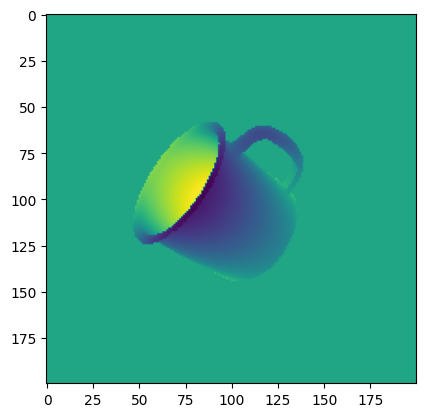

In [11]:
key = jax.random.split(key, 2)[0]
gt_img = render_img(translation, *random_angles(key))
fig, ax = plt.subplots(1)
ax.imshow(gt_img[0,...])

In [12]:
N = 400
lr = 1
@jax.jit
def fit_img(init_theta, init_phi, init_omega, gt_img):
    def loop_body(i, state):
        theta, phi, omega, losses = state
        loss, grads = loss_and_grad(theta, phi, omega, gt_img)
        theta_grad, phi_grad, omega_grad = grads
        return (theta - lr * theta_grad,
                phi   - lr * phi_grad,
                omega - lr * omega_grad,
                losses.at[i].set(loss))
    init_state = init_theta, init_phi, init_omega, jnp.zeros(N)
    return jax.lax.fori_loop(0, N, loop_body, init_state)

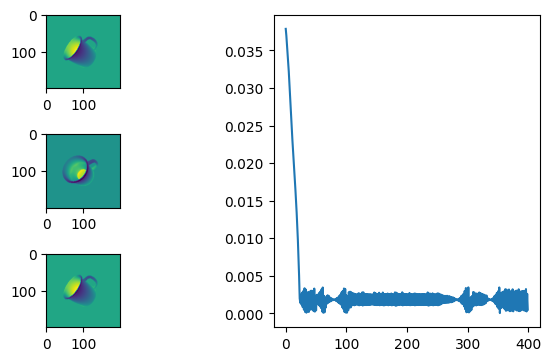

In [13]:
key = jax.random.split(key, 2)[0]
init_theta, init_phi, init_omega = random_angles(key)
theta, phi, omega, losses = fit_img(init_theta, init_phi, init_omega, gt_img)

fig, axd = plt.subplot_mosaic([['gt',   'losses'],
                               ['init', 'losses'],
                               ['fin',  'losses']],
                              figsize=(6.0, 3.5), layout="constrained")
axd['gt'].imshow(gt_img[0,...])
axd['init'].imshow(render_img(translation, init_theta, init_phi, init_omega)[0,...])
axd['fin'].imshow(render_img(translation, theta, phi, omega)[0,...])
axd['losses'].plot(losses)

In [14]:
thetas = jnp.linspace(0, 2*jnp.pi, 50)
phis   = jnp.linspace(0, jnp.pi/2, 13)
omegas = jnp.linspace(0, 2*jnp.pi, 50)
meshgrid = jnp.meshgrid(thetas, phis, omegas, indexing='ij')

In [15]:
meshgrid[0].flatten().shape

(32500,)

In [16]:
loss_grid = jax.jit(lambda: jax.lax.map(lambda l: loss_fn(*l, gt_img),
                            [a.flatten() for a in meshgrid]))()
loss_grid = loss_grid.reshape(meshgrid[0].shape)

In [17]:
loss_grid.shape

(50, 13, 50)

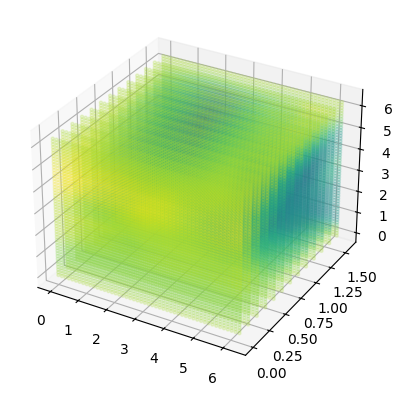

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*[a.flatten() for a in meshgrid], c=loss_grid.flatten(), marker='.', alpha=0.2)
plt.show()